# Functions for County Data Analysis
## collected function
Contains the following fields
* date : The date of entry. 
* tests : The average number of tests in the 7 days leading up to the date.
* pos : The positive percentage in the 7 days leading up to the date.
* deaths: The deaths up to the date given
* estimate : The Blake/Ellis estimate for COVID-19 patients on a given day, based on test positivity and reported cases

In [1]:
import json
import datetime
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def smoothForFields(list, field, consecutive=7):
    """
    Given an array of objects with numerical attributes, leave the first entries alone,
    and then average the consecutive entries from the number of consecutive entries requested. 
    """
    def averaged(array, idx):
        if (idx < consecutive):
            return array[idx]
        else:
            return sum(array[idx-consecutive:idx])/consecutive
        
    newArray = [l[field] for l in list]
    return [averaged(newArray, idx) for (idx, e) in enumerate(newArray)] 

def collected(jsonFile,starting = 0):
    """
    Average, collect, and sort the fields in the provided entry. In the result. 
    * data is the 
    """
    entries = json.load(open(jsonFile))["data"]
    r = [ {
        "dataDate": t['date'],
        "cases": t['cases'],
        "deaths": t['deaths'],
        "tests": t['tests']
        } for t in entries[starting:]]
    r.sort( key=lambda x:x['dataDate'])
    
    newCases = smoothForFields(entries, 'cases', 10) 
    newTests = smoothForFields(entries, 'tests', 10)
    windows = [
        {'date': r[i]['dataDate'],
         'cases': max(newCases[i]-newCases[i-7],0),
         'tests': max(newTests[i]-newTests[i-7],0),
         'deaths': r[i]['deaths']
         }
        for i in range(7,len(r))
        ]

    windows = [{
        'date' : w['date'],
        'cases' : w['cases'],
        'tests' : w['tests'],
        'deaths' : w['deaths'],
        'pos' : w['cases']/w['tests'] if (w['tests']) else 0
        }
        for w in windows
        ]
    windows = [
        {
            'date' : w['date'],
            'pos': w['pos'],
            'deaths' : w['deaths'],
            'estimate' : 28*w['cases']*math.sqrt(max(w['pos'],0.0))     
        }
        for w in windows
        ]
    windows = [
        {
        'date': w['date'],
        'pos': w['pos'],
            'deaths' : w['deaths'],
        'estimate': w['estimate']
        }
        for w in windows
        ]
    return windows


In [2]:
data=collected('../downloads/2020_09_15/lea.json',0)

## Plot of test positivity
Chaves County had a sudden spike in positive test rate, settling down to around 7% over the month of August and the first week of September

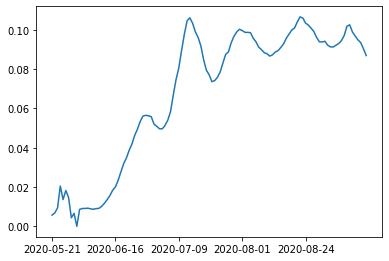

In [3]:

xvalues = [w['date'] for w in data]
yvalues = [w['pos'] for w in data]

figure = plt.figure()
ax = figure.add_axes([0.1,0.1,0.8,0.8])
ax.plot(xvalues, yvalues)
tickN = len(data)//23
ax.set_xticks([data[23*i]['date'] for i in range(0,tickN)])


## Blake and Ellis estimate
Blake and Ellis give the estimate:
```
actual = 28 * (confirmed 7-day cases) * sqrt(7-day positive fraction)
```
for the number of actual cases, given reported cases and positive test percentage, based on an assumption of 
10 day courses of the disease. 

https://covid19-projections.com/estimating-true-infections/

This estimate gives around 700 active cases (1% of the population) in Chavez county today.  

This would provide a 40% that a room of 50 people selected at random would have one person with COVID-19

39.49939328624637 Chance in a room of 50 people.


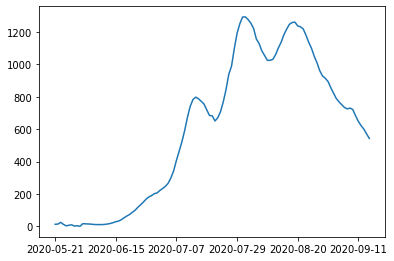

In [4]:
fiftyRoomOdds = 1-(.99)**50
print(f"{fiftyRoomOdds*100} Chance in a room of 50 people.")
evalues = [w['estimate'] for w in data]
figure2 = plt.figure()
ax = figure2.add_axes([0.1,0.1,0.8,0.8])
ax.plot(xvalues, evalues)
tickN = len(data)//22
ax.set_xticks([data[22*i]['date'] for i in range(0,tickN+1)])


In [5]:
total = sum(l['estimate'] for l in data[:-21])/10
estimatedCasesPerDeath = total/data[-1]['deaths']
print(f"To date there have been {estimatedCasesPerDeath} cases per death as of 21 days ago" )

To date there have been 276.78404403074774 cases per death as of 21 days ago


In [6]:
print(total)

5258.8968365842065
